In [1]:
using Distributions
using Random
using scBayesDeconv
using Plots

In [2]:
ndist = MixtureModel(
    MultivariateNormal[
        MultivariateNormal([0],ones(1,1)),
        MultivariateNormal([100],ones(1,1))
    ],
    [.5,.5]
    )

tdist = MixtureModel(
    MultivariateNormal[
        MultivariateNormal([0],ones(1,1))
    ],
    [1.]
    )

N = 1000

t = Matrix(transpose(rand(tdist,N)));
n = Matrix(transpose(rand(ndist,N)));
c = Matrix(transpose(rand(ndist,N)))+Matrix(transpose(rand(tdist,N)));
c = sort(c,dims=1);

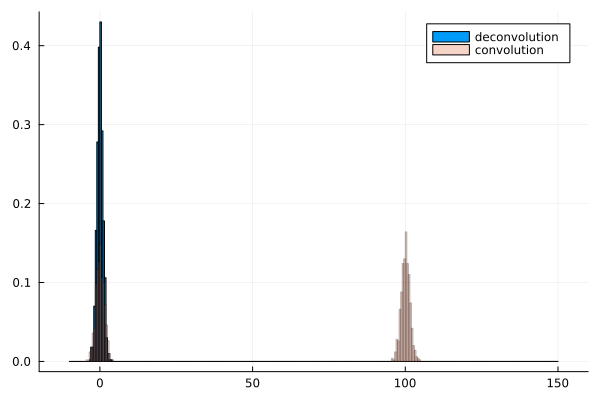

In [3]:
bins = range(-10,150,step=.5)
histogram(vec(t),normalize=true,bins=bins,label="deconvolution")
histogram!(vec(c),normalize=true,bins=bins,alpha=.3,label="convolution")

In [11]:
dn = finiteGaussianMixture(n,k=2,Σ0 = ones(1,1),κ0=0.01);

In [151]:
cartesian2lin(x,y,k1,k2) = x+(y-1)*(k1)
function lin2cartesian(x,k1,k2) 
    x1 = 0
    x2 = 0
    if x%k1==0 
        x1 = k1 
    else
        x1 = x%k1
    end
    
    x2 = (x-x1)÷k1+1

    return x1,x2
end

function gmloglikelihoodConvolution!(p::Matrix,X::Matrix,centers::Vector,covariances::Vector,weights::Vector,centersN::Vector,covariancesN::Vector,weightsN::Vector)

    kT = size(centers)[1]
    kN = size(centersN)[1]
    for j in 1:kT
        for k in 1:kN
            #Make MultivariateNormal from Distributions
            μ = centers[j]+centersN[k]
            Σ = covariances[j]+covariancesN[k]
            w = weights[j]*weightsN[k]
            dist = MultivariateNormal(μ,Σ)
            #Compute the logpdf for each sample
            for i in 1:size(X)[1]
                x = @views X[i,:]
                p[i,cartesian2lin(k,j,kN,kT)] = logpdf(dist,x)+log(w)
            end
        end
    end

    return
end

function gmlikelihoodConvolution!(p::Matrix,X::Matrix,centers::Vector,covariances::Vector,weights::Vector,centersN::Vector,covariancesN::Vector,weightsN::Vector)

    gmloglikelihoodConvolution!(p, X, centers, covariances, weights, centersN, covariancesN, weightsN)

    #Rescale
    p .-= maximum(p,dims=2)
    #Exp
    p .= exp.(p)
    #Normalize
    p ./= sum(p,dims=2)

    return
end

function scBayesDeconv.finiteGaussianMixtureDeconvolution(X::Matrix, Y::GaussianFiniteMixtureModel;
    k::Int,
    initialization::Union{String,Matrix} = "kmeans",
    α = 1,
    ν0 = 1,
    κ0 = 1,
    μ0 = nothing,
    Σ0 = nothing,
    ignoreSteps::Int = 1000, 
    saveSteps::Int = 1000,
    saveEach::Int = 10,
    verbose = false
    )

    nCells, dimensions = size(X)

    #Activate progress line
    if verbose 
        ProgressMeter.ijulia_behavior(:clear)
        prog = Progress(length(ignoreSteps+saveSteps))
    end 

    #Initialization
    centers,covariances,weights,identities = scBayesDeconv.initializationGaussianMixture(X,k,initialization)
    μ0,Σ0 = scBayesDeconv.initializationGaussianMixtureHyperparameters(X,μ0,Σ0)

    #Auxiliar functions
    kN = Y.components
    p = zeros(nCells,k*kN)
    votes = fill(0,k*kN) #Auxiliar for sampling from the Dirichlet distributions
    votesK = fill(0,k) #Auxiliar for sampling from the Dirichlet distributions
    vote = fill(0,k*kN) #Auxiliar for sampling from the Dirichlet distributions

    saveIds = Vector{Int}[]
    saveDist = MixtureModel[]
    saveN = Int[]

    nSamples = length(Y.samples)
    nRange = range(1,nSamples,step=1)
    centersN = [i.μ for i in Y.samples[1].components]
    covariancesN = [i.Σ for i in Y.samples[1].components]
    weightsN = Y.samples[1].prior.p
    identitiesN = copy(identities)

    m = zeros(dimensions)
    m2 = zeros(dimensions,dimensions)
    S2 = zeros(dimensions,dimensions)

    #Loop
    for step in 1:(ignoreSteps+saveSteps)

        #Sample noise distribution
        nSample = rand(nRange)
        centersN = [i.μ for i in Y.samples[nSample].components]
        covariancesN = [i.Σ for i in Y.samples[nSample].components]
        weightsN = Y.samples[nSample].prior.p        

        #Sample identities
        gmlikelihoodConvolution!(p,X,centers,covariances,weights,centersN,covariancesN,weightsN)
        votes .= 0 #Reset votes
        votesK .= 0 #Reset votes
        for i in 1:nCells           
            vote .= rand(Multinomial(1,@views(p[i,:])))
            pos = lin2cartesian(findfirst(vote.==1),kN,k)
            votes .+= vote
            votesK[pos[2]] += 1
            identities[i] = pos[2]
            identitiesN[i] = pos[1]
        end
        #Sample parameters
            #Sample weights
        weights .= rand(Dirichlet(votesK.+α/k))
        for comp in 1:k
            idsT = identities.==comp

            if votesK[comp] > dimensions #Check if we have enough statistical power to compute the wishart  

                #Sample covariance
                m2 .= 0
                S2 .= 0   
                for compN in 1:kN
                    idsN = identitiesN.==compN
                    ids = idsN .& idsT
                    #Statistics
                    aux = (reshape(mean(X[ids,:],dims=1),dimensions)-centersN[compN]-centers[comp])
                    m2 .+= votes[cartesian2lin(comp,compN,k,kN)]*aux*transpose(aux)
                    S2 .+= votes[cartesian2lin(comp,compN,k,kN)]*(cov(@views(X[ids,:]),corrected=false)-covariancesN[compN])
                end
                # println(votes,m/votesK[comp],S2/votesK[comp])
                for i in 1:dimensions
                    if S2[i,i] < 0
                        S2[i,i] = 0
                    end
                end
                neff = votesK[comp]+ν0+1

                Σeff = S2 + m2 + κ0*(centers[comp]-μ0)*transpose((centers[comp]-μ0)) + Σ0
                Σeff = (Σeff+transpose(Σeff))/2 #Reinforce hemicity
                covariances[comp] = rand(InverseWishart(neff,Σeff))
                #Sample centers
                m .= 0
                S2 .= 0   
                for compN in 1:kN
                    idsN = identitiesN.==compN
                    ids = idsN .& idsT
                    s = inv(covariances[comp]+covariancesN[compN])
                    #Statistics
                    # println((votes[cartesian2lin(comp,compN,k,kN)]*(reshape(mean(X[ids,:],dims=1),dimensions)-centersN[compN])+κ0*μ0))
                    m .+= s*(votes[cartesian2lin(comp,compN,k,kN)]*(reshape(mean(X[ids,:],dims=1),dimensions)-centersN[compN])+κ0*μ0)
                    S2 .+= s*(votes[cartesian2lin(comp,compN,k,kN)]+κ0)
                end
                S2 = inv(S2)
                m = S2*m
                centers[comp] .= rand(MultivariateNormal(m,S2))

            end
        end

        #Save
        if step >= ignoreSteps && step%saveEach == 0
            #rel = relabeling(identities,identitiesRef)
            dist = MixtureModel(MultivariateNormal[[MultivariateNormal(copy(i),copy(j)) for (i,j) in zip(centers,covariances)]...],copy(weights))
            push!(saveDist,deepcopy(dist))
            push!(saveIds,copy(identities))
            push!(saveN)
        end

        #Show progress bar if verbose
        if verbose
            next!(prog,showvalues=[(:iter,step)])
        end

    end

    return GaussianFiniteMixtureModelDeconvolved(k,
                                Dict([  
                                        :α=>α,
                                        :ν0 => ν0,
                                        :κ0 => κ0,
                                        :μ0 => μ0,
                                        :Σ0 => Σ0
                                    ]),
                                saveDist,
                                saveIds,
                                saveN,
                                Y)
end


In [152]:
dt = finiteGaussianMixtureDeconvolution(c,dn,k=1,Σ0=ones(1,1),κ0=0.01,ν0=0.01);

In [153]:
mean([i.components[1].Σ for i in dt.samples])

1×1 PDMats.PDMat{Float64, Matrix{Float64}}:
 0.9146249506733205

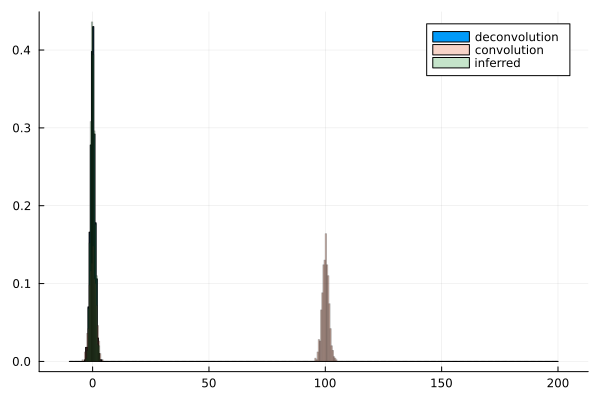

In [155]:
bins = range(-10,200,step=.5)
histogram(vec(t),normalize=true,bins=bins,label="deconvolution")
histogram!(vec(c),normalize=true,bins=bins,alpha=.3,label="convolution")

tt = rand(dt.samples[1],1000)
histogram!(vec(tt),normalize=true,bins=bins,alpha=.3,label="inferred")


lin2cartesian (generic function with 1 method)

In [102]:
for i in 1:3
    for j in 1:4
        println((i,j),cartesian2lin(i,j,3,4),lin2cartesian(cartesian2lin(i,j,3,4),3,4))
    end
end

(1, 1)1(1, 1)
(1, 2)4(1, 2)
(1, 3)7(1, 3)
(1, 4)10(1, 4)
(2, 1)2(2, 1)
(2, 2)5(2, 2)
(2, 3)8(2, 3)
(2, 4)11(2, 4)
(3, 1)3(3, 1)
(3, 2)6(3, 2)
(3, 3)9(3, 3)
(3, 4)12(3, 4)
